# Investigate development of MC error

In [1]:
from hypnettorch.utils import misc
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.spatial.distance import cdist
import sys
from time import time
import torch

# Pretend that notebook is located in base directory of this repo.
curr_dir = os.path.basename(os.path.abspath(os.curdir))
base_dir = os.path.abspath('../..')
if curr_dir == 'nngp' and base_dir != sys.path[0]:
    sys.path.insert(0, base_dir)

from data.gmm_utils import get_circle_gmm_instance
from nngp import MLPKernel

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = 'cpu'

In [2]:
def compute_kernels(data, config_dict):
    # Compute kernel matrices.
    for k in config_dict:
        start = time()
        if k['name'] == 'rbf':
            rbf_kernel = RBF()
            K = rbf_kernel(data.detach().cpu().numpy())
        else:
            mlp_kernel = MLPKernel(sigma2_w=1., sigma2_b=1., **k['params'])
            if k['name'].startswith('analytic'):
                K = mlp_kernel.kernel_analytic(data, **k['kernel_params']).numpy() 
            elif k['name'].startswith('efficient'):
                K = mlp_kernel.kernel_efficient(data, **k['kernel_params']).numpy()
            else:
                K = mlp_kernel.kernel_mc(data, **k['kernel_params']).numpy() 
        k['kernel'] = K
        print('Kernel "%s" computation took %f seconds.' % (k['name'], time()-start))

In [3]:
def kernel_estimation_error(title, kernel_dicts, show_plots=True):
    # Note, `mc_size == -1` means the efficient kernel was used.
    K_dict = {}
    for d in kernel_dicts:
        if d['name'].startswith('analytic'):
            assert 0 not in K_dict.keys()
            K_dict[0] = d['kernel']
            
            nan_mask = np.isnan(d['kernel'])
            if np.any(nan_mask):
                print('%s has %d nan entries!' % (d['name'], nan_mask.sum()))
        elif d['name'].startswith('efficient'):
            assert -1 not in K_dict.keys()
            K_dict[-1] = d['kernel']
        else:
            assert 'num_samples' in d['kernel_params']
            num_mc = d['kernel_params']['num_samples']
            assert num_mc not in K_dict.keys()
            K_dict[num_mc] = d['kernel']

    err_dict = {}
    for k, v in K_dict.items():
        if k == 0:
            continue
        # Compute relative error
        err_dict[k] = np.abs(K_dict[k] - K_dict[0]) / K_dict[0]

    mc_sizes = list(err_dict.keys())
    mc_sizes.sort()
    err_means = [err_dict[n][~nan_mask].mean() for n in mc_sizes]
    err_stds = [err_dict[n][~nan_mask].std() for n in mc_sizes]
    
    if show_plots:
        plt.title(title)
        plt.errorbar(mc_sizes, err_means, yerr=err_stds, fmt='.k')
        plt.xscale('log')
        plt.show()

        for n in mc_sizes:
            plt.title(title + ' MC-%d' % n)
            plt.hist(K_dict[n].flatten())
            plt.show()
    
    return (mc_sizes, err_means, err_stds)

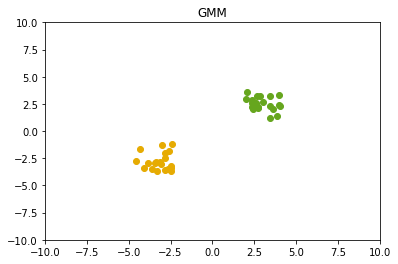

In [4]:
if False:
    means = [np.array([-2, -2]), np.array([2, 2])]
    covs = [1 * np.eye(len(mean)) for mean in means]
    modes = get_gmm_tasks(means=means, covs=covs, num_train=10,
                          num_test=100)
    data = GMMData(modes, classification=True, use_one_hot=False)
else:
    data = get_circle_gmm_instance(sigmas=[.5]*2, num_train=20,
                                   num_test=100, use_one_hot=False,
                                   radius=4, offset=-np.pi/4,
                                   rseed=1)

X = data.get_train_inputs()
Y = data.get_train_outputs().squeeze()

colors = misc.get_colorbrewer2_colors(family='Dark2')

plt.title('GMM')
plt.scatter(X[Y==0,0], X[Y==0,1], c=colors[4])
plt.scatter(X[Y==1,0], X[Y==1,1], c=colors[5])
plt.ylim(-10, 10)
plt.xlim(-10, 10)
plt.show()

# We use symmetrical values -1 / 1 for classification
Y[Y==0] = -1

X_torch = data.input_to_torch_tensor(X, device=device)

In [5]:
kernels = [
    ### Relu ###
    {'name': 'analytic_relu_1l', 'params': {'n_layer': 1, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {}},
    {'name': 'relu_1l_mc100', 'params': {'n_layer': 1, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 100}},
    {'name': 'relu_1l', 'params': {'n_layer': 1, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'relu_1l_mc10k', 'params': {'n_layer': 1, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 10000}},
    {'name': 'relu_1l_mc100k', 'params': {'n_layer': 1, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 100000}},
    
    {'name': 'analytic_relu_2l', 'params': {'n_layer': 2, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {}},
    {'name': 'relu_2l_mc100', 'params': {'n_layer': 2, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 100}},
    {'name': 'relu_2l', 'params': {'n_layer': 2, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'relu_2l_mc10k', 'params': {'n_layer': 2, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 10000}},
    {'name': 'relu_2l_mc100k', 'params': {'n_layer': 2, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 100000}},
    
    {'name': 'analytic_relu_4l', 'params': {'n_layer': 4, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {}},
    {'name': 'relu_4l_mc100', 'params': {'n_layer': 4, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 100}},
    {'name': 'relu_4l', 'params': {'n_layer': 4, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'relu_4l_mc10k', 'params': {'n_layer': 4, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 10000}},
    {'name': 'relu_4l_mc100k', 'params': {'n_layer': 4, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 100000}},
    
    {'name': 'analytic_relu_8l', 'params': {'n_layer': 8, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {}},
    {'name': 'relu_8l_mc100', 'params': {'n_layer': 8, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 100}},
    {'name': 'relu_8l', 'params': {'n_layer': 8, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'relu_8l_mc10k', 'params': {'n_layer': 8, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 10000}},
    {'name': 'relu_8l_mc100k', 'params': {'n_layer': 8, 'nonlinearity': torch.nn.ReLU()},
     'kernel_params': {'num_samples': 100000}},
    
    ### Error Function ###
    {'name': 'analytic_erf_1l', 'params': {'n_layer': 1, 'nonlinearity': torch.erf},
     'kernel_params': {}},
    {'name': 'erf_1l_mc100', 'params': {'n_layer': 1, 'nonlinearity': torch.erf},
     'kernel_params': {'num_samples': 100}},
    {'name': 'erf_1l', 'params': {'n_layer': 1, 'nonlinearity': torch.erf},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'erf_1l_mc10k', 'params': {'n_layer': 1, 'nonlinearity': torch.erf},
     'kernel_params': {'num_samples': 10000}},
    {'name': 'erf_1l_mc100k', 'params': {'n_layer': 1, 'nonlinearity': torch.erf},
     'kernel_params': {'num_samples': 100000}},

    {'name': 'analytic_erf_2l', 'params': {'n_layer': 2, 'nonlinearity': torch.erf},
     'kernel_params': {}},
    {'name': 'erf_2l_mc100', 'params': {'n_layer': 2, 'nonlinearity': torch.erf},
     'kernel_params': {'num_samples': 100}},
    {'name': 'erf_2l', 'params': {'n_layer': 2, 'nonlinearity': torch.erf},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'erf_2l_mc10k', 'params': {'n_layer': 2, 'nonlinearity': torch.erf},
     'kernel_params': {'num_samples': 10000}},
    {'name': 'erf_2l_mc100k', 'params': {'n_layer': 2, 'nonlinearity': torch.erf},
     'kernel_params': {'num_samples': 100000}},
    
    {'name': 'analytic_erf_4l', 'params': {'n_layer': 4, 'nonlinearity': torch.erf},
     'kernel_params': {}},
    {'name': 'erf_4l_mc100', 'params': {'n_layer': 4, 'nonlinearity': torch.erf},
     'kernel_params': {'num_samples': 100}},
    {'name': 'erf_4l', 'params': {'n_layer': 4, 'nonlinearity': torch.erf},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'erf_4l_mc10k', 'params': {'n_layer': 4, 'nonlinearity': torch.erf},
     'kernel_params': {'num_samples': 10000}},
    {'name': 'erf_4l_mc100k', 'params': {'n_layer': 4, 'nonlinearity': torch.erf},
     'kernel_params': {'num_samples': 100000}},
    
    {'name': 'analytic_erf_8l', 'params': {'n_layer': 8, 'nonlinearity': torch.erf},
     'kernel_params': {}},
    {'name': 'erf_8l_mc100', 'params': {'n_layer': 8, 'nonlinearity': torch.erf},
     'kernel_params': {'num_samples': 100}},
    {'name': 'erf_8l', 'params': {'n_layer': 8, 'nonlinearity': torch.erf},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'erf_8l_mc10k', 'params': {'n_layer': 8, 'nonlinearity': torch.erf},
     'kernel_params': {'num_samples': 10000}},
    {'name': 'erf_8l_mc100k', 'params': {'n_layer': 8, 'nonlinearity': torch.erf},
     'kernel_params': {'num_samples': 100000}},
    
    ### Cosine ###
    {'name': 'analytic_cos_1l', 'params': {'n_layer': 1, 'nonlinearity': torch.cos},
     'kernel_params': {}},
    {'name': 'cos_1l_mc100', 'params': {'n_layer': 1, 'nonlinearity': torch.cos},
     'kernel_params': {'num_samples': 100}},
    {'name': 'cos_1l', 'params': {'n_layer': 1, 'nonlinearity': torch.cos},
     'kernel_params': {'num_samples': 1000}},
    {'name': 'cos_1l_mc10k', 'params': {'n_layer': 1, 'nonlinearity': torch.cos},
     'kernel_params': {'num_samples': 10000}},
    {'name': 'cos_1l_mc100k', 'params': {'n_layer': 1, 'nonlinearity': torch.cos},
     'kernel_params': {'num_samples': 100000}},
]

compute_kernels(X_torch, kernels)

Kernel "analytic_relu_1l" computation took 0.000959 seconds.
Kernel "relu_1l_mc100" computation took 0.003509 seconds.
Kernel "relu_1l" computation took 0.005993 seconds.
Kernel "relu_1l_mc10k" computation took 0.030450 seconds.
Kernel "relu_1l_mc100k" computation took 0.224828 seconds.
Kernel "analytic_relu_2l" computation took 0.000590 seconds.
Kernel "relu_2l_mc100" computation took 0.005468 seconds.
Kernel "relu_2l" computation took 0.006491 seconds.
Kernel "relu_2l_mc10k" computation took 0.046554 seconds.
Kernel "relu_2l_mc100k" computation took 0.419679 seconds.
Kernel "analytic_relu_4l" computation took 0.000900 seconds.
Kernel "relu_4l_mc100" computation took 0.013290 seconds.
Kernel "relu_4l" computation took 0.018671 seconds.
Kernel "relu_4l_mc10k" computation took 0.092457 seconds.
Kernel "relu_4l_mc100k" computation took 0.850583 seconds.
Kernel "analytic_relu_8l" computation took 0.001196 seconds.
Kernel "relu_8l_mc100" computation took 0.031066 seconds.
Kernel "relu_8l" 

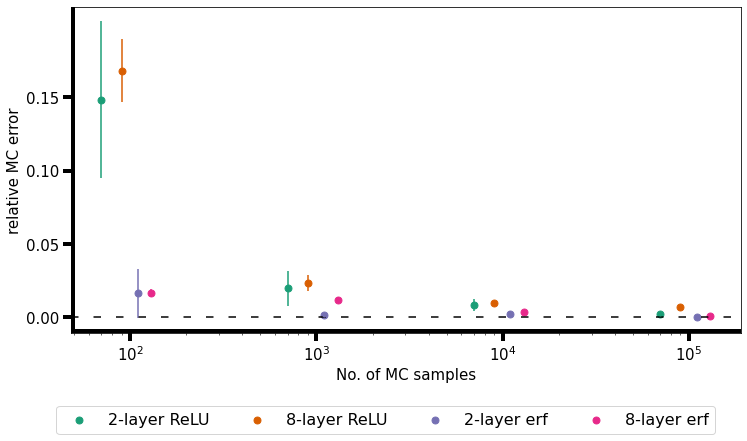

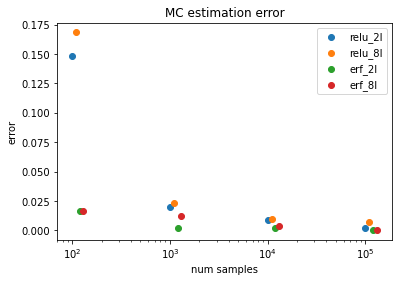

In [6]:
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FuncFormatter, MaxNLocator

arch_names = ['relu_1l', 'relu_2l', 'relu_4l', 'relu_8l',
              'erf_1l', 'erf_2l', 'erf_4l', 'erf_8l']

arch_names = ['relu_2l', 'relu_8l',
              'erf_2l', 'erf_8l']

arch_labels = ['2-layer ReLU', '8-layer ReLU',
               '2-layer erf', '8-layer erf']

#arch_names = ['cos_1l']
#arch_labels = ['1-layer Cosine']

errs = {}
errs_lbls = {}

for i, name in enumerate(arch_names):
    curr_kernels = [k for k in kernels if name in k['name']]
    curr_errs = kernel_estimation_error(name, curr_kernels, show_plots=False)

    errs[name] = curr_errs
    errs_lbls[name] = arch_labels[i]

colors = misc.get_colorbrewer2_colors(family='Dark2')
    
small_font = FontProperties()
small_font.set_size(16)
ts, lw, ms = 15, 8, 140 # text fontsize, line width, marker size
figsize = (12, 6)

fig, axes = plt.subplots(figsize=figsize)
    
#plt.title('MC estimation error')
for i, aname in enumerate(errs.keys()):
    sizes = [s + 2*(i-1.5)*s/10 for s in errs[aname][0]]
    plt.scatter(sizes, errs[aname][1], c=colors[i], s=lw*6,
                label=errs_lbls[aname])
    plt.errorbar(sizes, errs[aname][1], yerr=errs[aname][2], c=colors[i],
                 fmt='.')
plt.xscale('log')

plt.legend(prop=small_font, loc='upper center', 
           bbox_to_anchor=(0.47, -0.2), ncol=5)
plt.ylabel('relative MC error', fontsize=ts)
plt.xlabel('No. of MC samples', fontsize=ts)

plt.axhline(y=0, color='k', linestyle=(0, (5, 10)))

axes.grid(False)
axes.set_facecolor('w')
axes.axhline(y=axes.get_ylim()[0], color='k', lw=lw)
axes.axvline(x=axes.get_xlim()[0], color='k', lw=lw)
#plt.xticks([0, 1, 2, 3], fontsize=ts)
plt.xticks(fontsize=ts)
plt.yticks([0, .05, .1, .15], fontsize=ts)
axes.tick_params(axis='both', length=lw, direction='out', width=lw/2.)

filename = 'mc_error'
if filename is not None:
    fpath = filename
    plt.savefig(fpath + '.pdf', bbox_inches='tight')
    plt.savefig(fpath + '.png', bbox_inches='tight')

plt.show()


#########################
plt.title('MC estimation error')
for i, aname in enumerate(errs.keys()):
    sizes = [s + i*s/10 for s in errs[aname][0]]
    plt.scatter(sizes, errs[aname][1], label=aname)
plt.xscale('log')
plt.xlabel('num samples')
plt.ylabel('error')
plt.legend()
plt.show()
